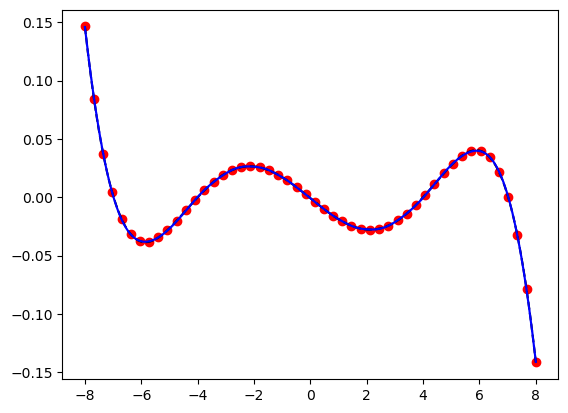

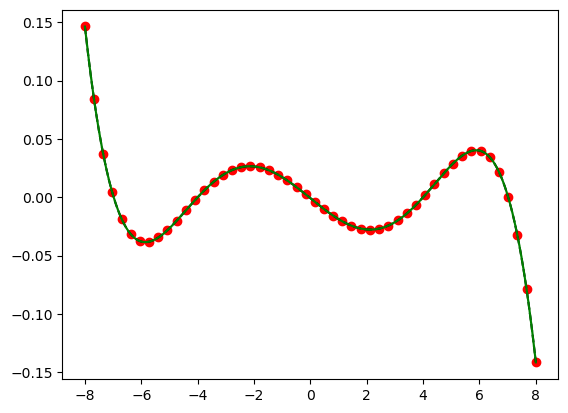

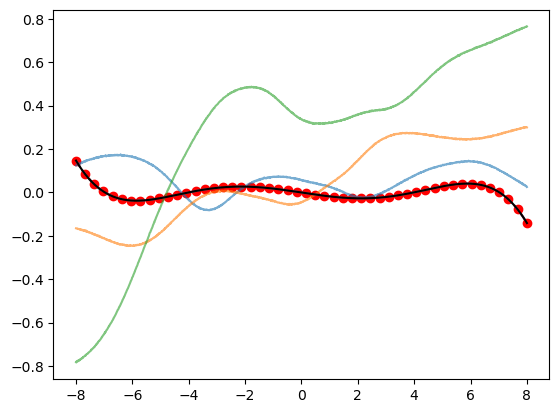

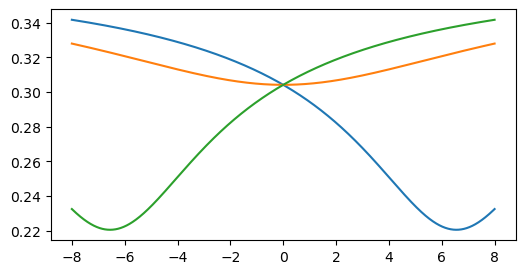

Optimized m,b,sigma_mb are:  0.6153592154967666 4.4816890703380645 0.0047260814022316395


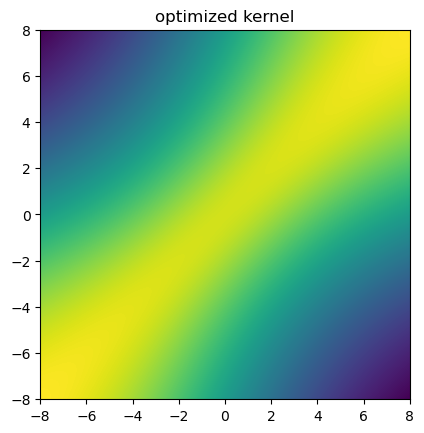

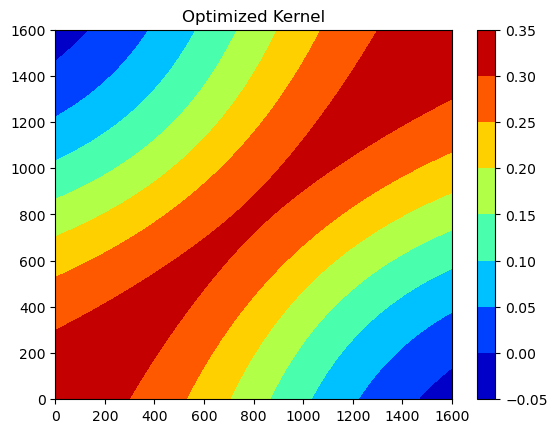

Original m,b,sigma_mb are:  1.0 1.0 0.0


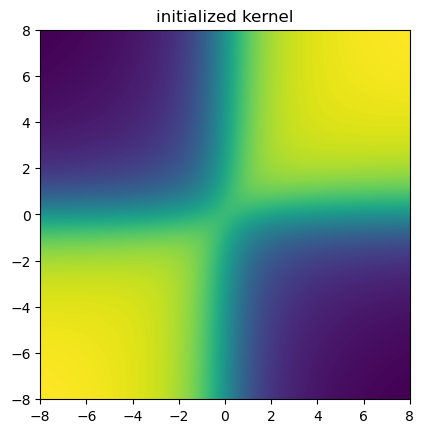

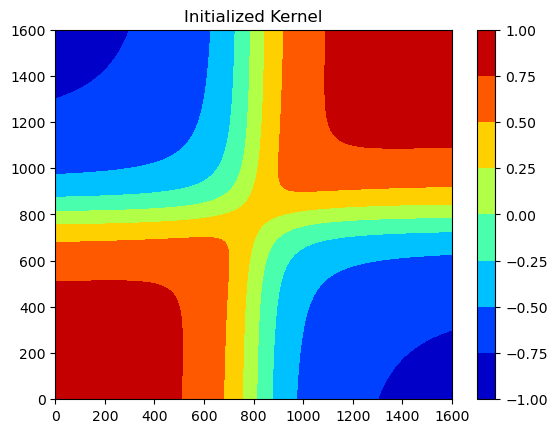

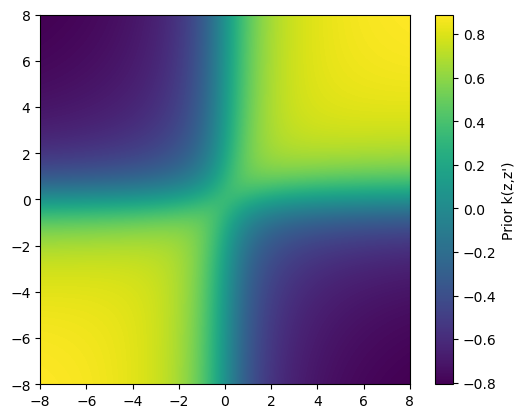

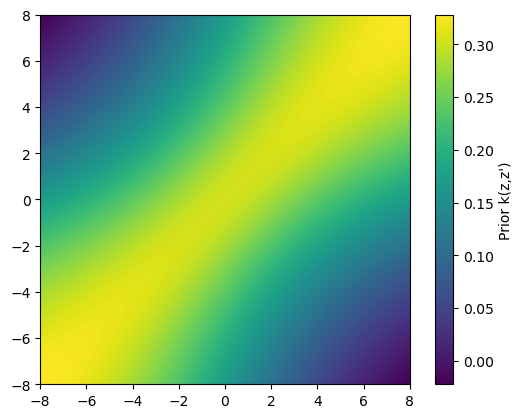

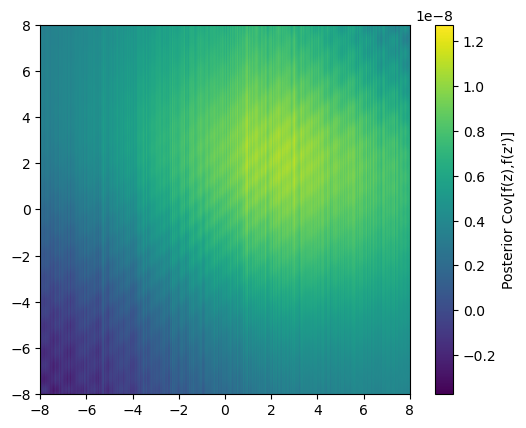

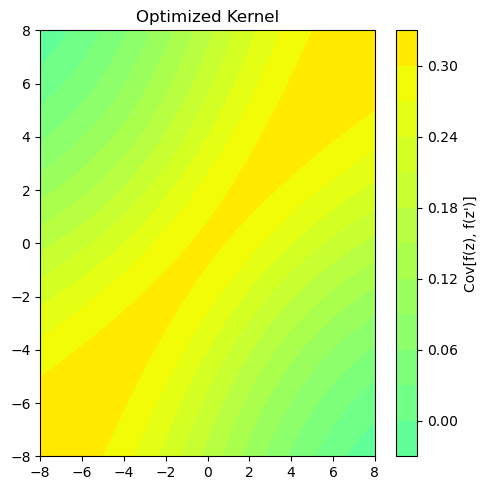

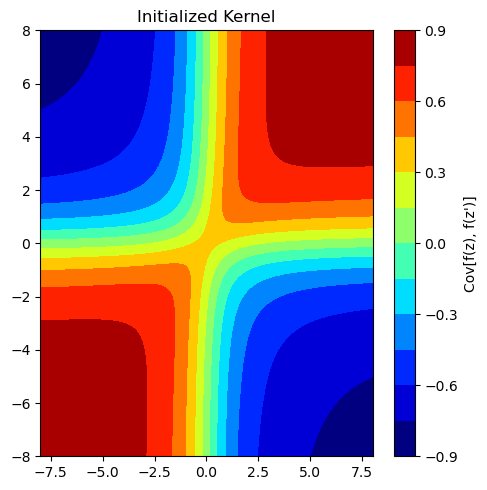

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------
# 1) Define the arcsin kernel with joint Gaussian (m,b)
# ------------------------------
def arcsin_kernel_joint_gaussian(z1, z2, sigma_m, sigma_b, sigma_mb, eps=1e-12):
    z1 = z1.reshape(-1,1)   # (N,1)
    z2 = z2.reshape(1,-1)   # (1,M)
    # numerator: Cov[m*z1 + b, m*z2 + b]
    num = sigma_m**2 * (z1 @ z2) + sigma_mb * (z1 + z2) + sigma_b**2
    # denominator pieces
    S1 = sigma_m**2 * (z1**2) + 2*sigma_mb*z1 + sigma_b**2 +1
    S2 = sigma_m**2 * (z2**2) + 2*sigma_mb*z2 + sigma_b**2  +1
    # ensure positivity
    S1 = np.maximum(S1, eps)
    S2 = np.maximum(S2, eps)
    rho = num / np.sqrt(S1 @ S2)
    rho = np.clip(rho, -1+eps, 1-eps)
    return (2/np.pi) * sigma_m**2 * np.arcsin(rho)

# ------------------------------
# 2) Negative log marginal likelihood
#    parameterize via log_sm, log_sb, phi where sigma_mb = tanh(phi)*sigma_m*sigma_b
# ------------------------------
def neg_log_marginal_likelihood(params, z, y, noise_jitter=1e-6):
    log_sm, log_sb, phi = params
    sigma_m = np.exp(log_sm)
    sigma_b = np.exp(log_sb)
    rho     = np.tanh(phi)
    sigma_mb = rho * sigma_m * sigma_b

    # build kernel
    K = arcsin_kernel_joint_gaussian(z, z, sigma_m, sigma_b, sigma_mb)
    # add tiny noise for stability
    K[np.diag_indices(len(z))] += noise_jitter

    # Cholesky
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return np.inf

    # compute alpha = K^{-1} y via solves
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    # log det K = 2 sum log diag(L)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    n = len(z)

    return 0.5 * (y @ alpha) + 0.5 * logdet + 0.5 * n * np.log(2*np.pi)

# ------------------------------
# 3) GP regression with eigen-decomp inversion
# ------------------------------
def gp_regression_eig_joint_gaussian(z_train, y_train, z_test,
                                     sigma_m, sigma_b, sigma_mb,
                                     sigma_n=1e-6, eigen_threshold=1e-8):
    # training covariances
    K = arcsin_kernel_joint_gaussian(z_train, z_train, sigma_m, sigma_b, sigma_mb)
    K += sigma_n**2 * np.eye(len(z_train))
    # cross cov
    K_s = arcsin_kernel_joint_gaussian(z_train, z_test, sigma_m, sigma_b, sigma_mb)
    # test cov
    K_ss = arcsin_kernel_joint_gaussian(z_test, z_test, sigma_m, sigma_b, sigma_mb)

    # eigen decomposition
    evals, evecs = np.linalg.eigh(K)
    evals = np.maximum(evals, eigen_threshold)
    Kinv = (evecs * (1.0/evals)) @ evecs.T

    # predictive mean
    mu = K_s.T @ (Kinv @ y_train)
    # predictive covariance
    cov = K_ss - K_s.T @ (Kinv @ K_s)
    return mu, cov

# ------------------------------
# 4) Example: fit and plot
# ------------------------------
if __name__ == "__main__":
    # generate data
    zrnge = 8  
    dz = 0.01 
    zgrid = np.arange(-zrnge, zrnge + dz, dz).reshape(-1, 1)
    def fz(z):
        c = 2
        return ((-(z+7)*(z+4)*z*(z-4)*(z-7) + c*(z**2-16))/40000).flatten()

    # def fz(z):
    #     # Base function with varying frequency across the domain
    #     base = np.sin(z**2 / 4) * np.cos(z / 2)
        
    #     # Add location-dependent amplitude modulation
    #     amplitude = 0.5 + 0.5 * np.tanh(z / 2)
        
    #     # Add sharp transition in the middle
    #     transition = 0.2 * np.tanh(5 * z)
        
    #     # Create a function that behaves differently in different regions
    #     result = (base * amplitude + transition) / 20
        
    #     return result.flatten()

    # def fz(z):
    #     lam = np.where(z < 0, 1.0, 5.0)   # piecewise decay rate
    #     return np.exp(-lam * z).flatten()

    fgrid = fz(zgrid)

    # training subset
    n_train =  50
    idx = np.linspace(0, len(zgrid)-1, n_train, dtype=int)
    z_train = zgrid[idx]
    y_train = fgrid[idx]
    # originals:
    # s_m0, s_b0, s_mb0 = 0.5, 0.25, 0.0
    s_m0, s_b0, s_mb0 = 1.0, 1.0, 0.0

    ## --- optimize ---
    init = [np.log(s_m0), np.log(s_b0), s_mb0]
    res = minimize(neg_log_marginal_likelihood, init, 
                   args=(z_train,y_train), 
                   bounds=[(-1.5,1.5),(-1.5,1.5),(None,None)])
    log_sm, log_sb, phi = res.x
    sigma_m_opt, sigma_b_opt = np.exp([log_sm,log_sb])
    rho_opt = np.tanh(phi)
    sigma_mb_opt = rho_opt*sigma_m_opt*sigma_b_opt


    # --- predictions ---
    mu_0, cov_0 = gp_regression_eig_joint_gaussian(z_train,y_train,zgrid,s_m0,s_b0,s_mb0)
    mu_opt, cov_opt = gp_regression_eig_joint_gaussian(z_train,y_train,zgrid,sigma_m_opt,sigma_b_opt,sigma_mb_opt)
    std_0 = np.sqrt(np.clip(np.diag(cov_0),0, np.inf))
    std_opt = np.sqrt(np.clip(np.diag(cov_opt),0, np.inf))

    # 1) Original vs optimized
    # plt.figure(figsize=(8,4))
    # plt.plot(zgrid, fgrid, 'k--', label='True')
    # plt.scatter(z_train, y_train, c='r', label='Train')
    # plt.plot(zgrid, mu_0, 'b-', label='Mean (orig)')
    # plt.plot(zgrid, mu_opt, 'g-', label='Mean (opt)')
    # plt.fill_between(zgrid.flatten(), mu_0-2*std_0,  mu_0+2*std_0, color='b', alpha=0.2, label='±2σ (orig)')
    # plt.fill_between(zgrid.flatten(), mu_opt-2*std_opt,  mu_opt+2*std_opt, color='g', alpha=0.2, label='±2σ (opt)')
    # # plt.legend()
    # # plt.title("Original vs Optimized GP")
    # # plt.savefig("Original_vs_Optimized_GP.pdf", transparent=True)
    # plt.show()

    plt.plot(zgrid, fgrid, 'k--', label='True')
    plt.scatter(z_train, y_train, c='r', label='Train')
    plt.plot(zgrid, mu_0, 'b-', label='Mean (orig)')
    plt.fill_between(zgrid.flatten(), mu_0-2*std_0,  mu_0+2*std_0, color='b', alpha=0.2, label='±2σ (orig)')
    # plt.legend()
    # plt.title("True Function vs Standard Normal parameters on Kernel GP")
    # plt.savefig("true_vs_std_normal_GP_2.pdf", transparent=True)
    plt.show()


    plt.plot(zgrid, fgrid, 'k--', label='True')
    plt.scatter(z_train, y_train, c='r', label='Train')
    plt.plot(zgrid, mu_opt, 'g-', label='Mean (optim)')
    plt.fill_between(zgrid.flatten(), mu_opt-2*std_opt,  mu_opt+2*std_opt, color='g', alpha=0.2, label='±2σ (optim)')
    # plt.legend()
    # plt.title("True Function vs Optimized parameters on Kernel GP")
    # plt.savefig("true_vs_optimized_GP_2.pdf", transparent=True)
    plt.show()

    # 2) Prior & posterior samples
    Kprior = arcsin_kernel_joint_gaussian(zgrid,zgrid,sigma_m_opt,sigma_b_opt,sigma_mb_opt) + 1e-6*np.eye(len(zgrid))
    pri_samps = np.random.multivariate_normal(np.zeros(len(zgrid)), Kprior, size=3)
    D = np.diag(std_opt**2)
    post_samps = np.random.multivariate_normal(mu_opt, cov=cov_opt + 1e-12*np.eye(len(zgrid)), size=3)

    # plt.figure(figsize=(8,4))
    for s in pri_samps: 
        plt.plot(zgrid, s, alpha=0.6)
    for s in post_samps: 
        plt.plot(zgrid, s, '--', alpha=0.6)
    plt.scatter(z_train,y_train,c='r'); 
    # plt.title("3 GP Prior (solid) / Posterior (dashed)")
    plt.plot(zgrid, fgrid, 'k-', label='True ODE')
    # plt.savefig("Prior_vs_Post_samples.pdf", transparent=True)
    plt.show()

    # 3) Marginal variance vs z for various 2×2 covariances
    plt.figure(figsize=(6,3))
    for rho_cur in [-0.9,0,0.9]:
        simga_mb_cur = rho_cur*sigma_m_opt*sigma_b_opt
        Kp = arcsin_kernel_joint_gaussian(zgrid,zgrid,sigma_m_opt,sigma_b_opt,simga_mb_cur)
        plt.plot(zgrid, np.diag(Kp), label=f'ρ={rho_cur}')
    # # plt.title("Prior Marginal Variance")
    # plt.legend()
    # plt.savefig("Prior_Marginal_Variance.pdf", transparent=True)
    plt.show()

    # # 4) Bonus: heatmap of Var[f(z)] over (z,ρ)
    # rhos = np.linspace(-0.99,0.99,200)
    # Z, R = np.meshgrid(zgrid.flatten(), rhos)
    # Var = np.zeros_like(Z)
    # for i, rho_cur in enumerate(rhos):
    #     simga_mb_cur = rho_cur*sigma_m_opt*sigma_b_opt
    #     Var[i,:] = arcsin_kernel_joint_gaussian(Z[i:i+1].T, Z[i:i+1], sigma_m_opt, sigma_b_opt, simga_mb_cur).diagonal()
    # plt.figure(figsize=(6,4))
    # plt.pcolormesh(Z, R, Var, shading='auto', cmap='viridis')
    # plt.colorbar(label='Var[f(z)]')
    # plt.xlabel('z'); plt.ylabel('ρ'); plt.title("Heatmap of Marginal Var vs z,ρ")
    # plt.show()

    K = arcsin_kernel_joint_gaussian(zgrid, zgrid, sigma_m_opt, sigma_b_opt, sigma_mb_opt)
    print("Optimized m,b,sigma_mb are: ",sigma_m_opt, sigma_b_opt, sigma_mb_opt)
    plt.imshow(K, extent=[-8,8,-8,8], origin='lower')
    # plt.colorbar(label='Cov[f(z),f(z\')]')
    # plt.savefig("Optimized_Kernel_imshow.pdf", transparent=True)
    plt.title("optimized kernel")
    plt.show()

    # fig, ax = plt.subplots(figsize=(6,6))
    # # heatmap
    # im = ax.imshow(K,
    #             extent=[zgrid.min(), zgrid.max(), zgrid.min(), zgrid.max()],
    #             origin='lower',
    #             cmap='viridis',
    #             aspect='equal')
    # # contour lines (choose as many levels as you like)
    # z = zgrid.flatten()   # shape (N,)

    # # 2) Make the mesh for contouring
    # X, Y = np.meshgrid(z, z)
    # levels = np.linspace(np.min(K), np.max(K), 12)
    # cs = ax.contour(X, Y,K,
    #                 levels=levels,
    #                 colors='white',
    #                 linewidths=0.8)

    # # 4) (Optional) Label each contour
    # ax.clabel(cs, inline=True, fontsize=8, fmt='%.1e')

    # # 5) Decoration
    # fig.colorbar(im, ax=ax, label="Cov[f(z), f(z')]")
    # ax.set_title("Optimized arcsin kernel (with contour lines)")
    # ax.set_xlabel("z")
    # ax.set_ylabel("z'")
    # plt.tight_layout()
    # plt.show()

    # 2) Make a contour-only figure
    nz = zgrid.shape[0]   # shape (zgrid,)
    
    fig, ax = plt.subplots()
    contour1 = ax.contourf(K.reshape(nz,nz), cmap='jet')
    ax.set_title("Optimized Kernel")
    # ax.set_xlabel('z')
    # ax.set_ylabel("z'")
    fig.colorbar(contour1, ax=ax)
    # plt.savefig("oprimized_kernel_contour.pdf", transparent=True)
    plt.show()

    # X, Y = np.meshgrid(z, z)
    # levels = np.linspace(np.min(K), np.max(K), 12)
    # fig, ax = plt.subplots(figsize=(6,6))
    # levels = np.linspace(np.min(K), np.max(K), 12)
    # cs = ax.contour(X, Y, K,
    #                 levels=levels,
    #                 cmap='viridis')
    # ax.clabel(cs, inline=True, fmt='%.2e', fontsize=8)

    # ax.set_title("Arcsin kernel contours")
    # ax.set_xlabel("z")
    # ax.set_ylabel("z'")
    # plt.tight_layout()
    # plt.show()



    K = arcsin_kernel_joint_gaussian(zgrid, zgrid, s_m0, s_b0, s_mb0)
    print("Original m,b,sigma_mb are: ",s_m0, s_b0, s_mb0)
    plt.imshow(K, extent=[-8,8,-8,8], origin='lower')
    # plt.colorbar(label='Cov[f(z),f(z\')]')
    # plt.title("Prior Covariance")
    # plt.savefig("initialized_Kernel_imshow.pdf", transparent=True)
    plt.title("initialized kernel")
    plt.show()

    nz = zgrid.shape[0]   # shape (zgrid,)
    
    fig, ax = plt.subplots()
    contour1 = ax.contourf(K.reshape(nz,nz), cmap='jet')
    ax.set_title("Initialized Kernel")
    # ax.set_xlabel('z')
    # ax.set_ylabel("z'")
    fig.colorbar(contour1, ax=ax)
    # plt.savefig("original_kernel_contour.pdf", transparent=True)
    plt.show()

    # plt.imshow(
    # cov_opt,
    # extent=[-8, 8, -8, 8],    # x and y both span your input range
    # origin='lower',           # so (–8,–8) is in the bottom‐left
    # cmap='viridis'
    # )
    # plt.colorbar(label='Posterior Covariance')
    # plt.xlabel('zʼ')
    # plt.ylabel('z')
    # plt.title('Posterior Predictive Covariance')
    # plt.show()

    K_prior = arcsin_kernel_joint_gaussian(zgrid, zgrid,s_m0, s_b0, s_mb0)
    plt.imshow(K_prior, extent=[-8,8,-8,8], origin='lower')
    plt.colorbar(label='Prior k(z,z\')')
    plt.show()


    K_prior_opt = arcsin_kernel_joint_gaussian(zgrid, zgrid,sigma_m_opt, sigma_b_opt, sigma_mb_opt)
    plt.imshow(K_prior_opt, extent=[-8,8,-8,8], origin='lower')
    plt.colorbar(label='Prior k(z,z\')')
    plt.show()

    plt.imshow(cov_opt, extent=[-8,8,-8,8], origin='lower')
    plt.colorbar(label='Posterior Cov[f(z),f(z\')]')        

    # plt.plot(zgrid, np.diag(K_prior), label='Prior σ²')
    # plt.plot(zgrid, np.diag(cov_opt), label='Posterior σ²')
    # plt.legend()
    plt.show()

    from matplotlib import colors

    # 1) Compute your two kernels
    K_opt  = arcsin_kernel_joint_gaussian(zgrid, zgrid, sigma_m_opt, sigma_b_opt, sigma_mb_opt)
    K_init = arcsin_kernel_joint_gaussian(zgrid, zgrid, s_m0,      s_b0,      s_mb0)

    # 2) Find the global min and max
    global_min = min(K_opt.min(),  K_init.min())
    global_max = max(K_opt.max(),  K_init.max())

    # 3) Create a shared Normalize instance
    norm = colors.Normalize(vmin=global_min, vmax=global_max)

    # 4) Plot optimized kernel
    fig, ax = plt.subplots(figsize=(5,5))
    X, Y = np.meshgrid(zgrid.flatten(), zgrid.flatten())
    cs1 = ax.contourf(X, Y, K_opt.reshape(len(zgrid),len(zgrid)),
                    levels=12,        # or omit to let contourf pick
                    norm=norm,        # <-- shared scale
                    cmap='jet')
    ax.set_title("Optimized Kernel")
    fig.colorbar(cs1, ax=ax, label="Cov[f(z), f(z')]")
    plt.tight_layout()
    plt.show()

    # 5) Plot initialized kernel with the *exact same* scale
    fig, ax = plt.subplots(figsize=(5,5))
    cs2 = ax.contourf(X, Y, K_init.reshape(len(zgrid),len(zgrid)),
                    levels=12,
                    norm=norm,        # <-- same Norm
                    cmap='jet')
    ax.set_title("Initialized Kernel")
    fig.colorbar(cs2, ax=ax, label="Cov[f(z), f(z')]")
    plt.tight_layout()
    plt.show()

    # plt.plot(zgrid, K_prior[:, 0], label='Prior k(z,0)')
    # plt.plot(zgrid, cov_opt[:, 0], label='Post cov(z,0)')
    # plt.legend()
    # plt.show()


    # # optimize hyperparameters
    # init = np.array([np.log(0.5), np.log(0.25), 0.0])  # [log_sm, log_sb, phi]
    # res = minimize(neg_log_marginal_likelihood, init,
    #                args=(z_train, y_train),
    #                method="L-BFGS-B",
    #                bounds=[(-5,5),(-5,5),(None,None)])
    # log_sm, log_sb, phi = res.x
    # sigma_m = np.exp(log_sm)
    # sigma_b = np.exp(log_sb)
    # rho     = np.tanh(phi)
    # sigma_mb = rho * sigma_m * sigma_b
    # print(f"Learned σₘ={sigma_m:.4f}, σ_b={sigma_b:.4f}, ρ={rho:.4f}")

    # # predict on all zgrid
    # mu, cov = gp_regression_eig_joint_gaussian(
    #     z_train, y_train, zgrid,
    #     sigma_m, sigma_b, sigma_mb,
    #     sigma_n=1e-12
    # )
    # std = np.sqrt(np.maximum(np.diag(cov), 0.0))

    # # plot
    # plt.figure(figsize=(8,5))
    # plt.plot(zgrid, fgrid, "k--", label="True $f(z)$")
    # plt.scatter(z_train, y_train, c="r", label="Training data")
    # plt.plot(zgrid, mu, "b", lw=2, label="GP mean")
    # plt.fill_between(zgrid.flatten(),
    #                  mu-2*std, mu+2*std,
    #                  color="blue", alpha=0.2, label="±2σ band")
    # plt.xlabel("z")
    # plt.ylabel("f(z)")
    # plt.title("GP Regression with Joint‐Gaussian (m,b)")
    # plt.legend()
    # plt.show()
